In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import functions
import numpy as np
import math, pyarrow.parquet as pq, os, glob
import pandas as pd

In [2]:
df, odf = functions.read_files(
    '2025-07-12','2025-07-28'
)
odf['recv_time'] = pd.to_datetime(odf['recv_time'])


In [ ]:
if 'recv_time' not in df.columns:
    df = df.reset_index()

PERIOD_BIG = '1h'
PERIOD_SMALL = '15min'
STEP   = 0.5
va_df      = functions.value_area(df.copy(), PERIOD_BIG, STEP)
delta      = functions.volume_delta(df.copy(), PERIOD_BIG).rename('volume_delta')
vpin       = functions.VPIN(df.copy(), PERIOD_SMALL, functions.BUCKET_SIZE, functions.WINDOW_LENGTH)
ofi        = functions.process_order_flow_imbalance(odf, PERIOD_SMALL)
rf         = functions.RF(va_df)
kyle_lambda= functions.vectorized_kyle_lambda(df.copy(), PERIOD_BIG)
cum_delta  = functions.cummulutive_delta(df.copy(), PERIOD_BIG)

price_bar = (
    df.set_index('recv_time')['price']
      .resample(PERIOD_SMALL)
      .last()
      .ffill()
      .rename('price')
)

indicators_df = pd.concat(
    [va_df, delta, vpin, rf, ofi, kyle_lambda, cum_delta], axis=1
).join(price_bar, how='left')

to_fill = ['POC_price','POC_volume','VAH','VAL','RF','cum_delta','Kyle_Lambda']
indicators_df[to_fill] = indicators_df[to_fill].ffill()


подсчет сигналов и выбор timestamp

In [ ]:
'''-----------------------пересечение цены VAH или VAL-----------------------'''
P = indicators_df['price']
H = indicators_df['VAH']
L = indicators_df['VAL']

P_prev = P.shift(1)
H_prev = H.shift(1)
L_prev = L.shift(1)

indicators_df['VAH_sell']  = (P <  H) & (P_prev >= H_prev)

indicators_df['VAL_buy'] = (P >  L) & (P_prev <= L_prev)
'''--------------------------------------------------------------------------'''


'--------------------------------------------------------------------------'

In [ ]:

'''-----------------------rotation factor-----------------------'''
rf_z = (indicators_df['RF'] - indicators_df['RF'].rolling(96).mean()) / indicators_df['RF'].rolling(96).std()
rf_buy  = rf_z < -1    # нижнее 16 %
rf_sell = rf_z > +1

indicators_df['rf_buy'] = rf_buy.fillna(False)
indicators_df['rf_sell'] = rf_sell.fillna(False)
'''--------------------------------------------------------------'''


'--------------------------------------------------------------'

In [ ]:

'''-----------------------kyle's lambda-----------------------'''
# kl_buy = kl < 0.05
# kl_sell = kl > 0.2

# indicators_df['kl_buy'] = kl_buy.fillna(False)
# indicators_df['kl_sell'] = kl_sell.fillna(False)
'''--------------------------------------------------------------'''


'--------------------------------------------------------------'

In [ ]:

'''-----------------------изменение ofi с отрицательного на положительное-----------------------'''
ofi_buy = (
    (indicators_df['OFI'] >= 0) &
    (indicators_df['OFI'].shift(1) <= -2)
)

ofi_sell = (
    (indicators_df['OFI'] <= 0) &
    (indicators_df['OFI'].shift(1) >= 2)
)

indicators_df['ofi_buy'] = ofi_buy.fillna(False)
indicators_df['ofi_sell'] = ofi_sell.fillna(False)
'''---------------------------------------------------------------------------------------------'''


'---------------------------------------------------------------------------------------------'

условие входа/выхода volume delta

In [ ]:

'''-----------------------изменение volume delta-----------------------'''
neg_delta = indicators_df['volume_delta'].ffill().clip(None, 0)
pos_delta = indicators_df['volume_delta'].ffill().clip(0, None)

avg_neg_delta = neg_delta.rolling('24h').mean().bfill()
avg_pos_delta = pos_delta.rolling('24h').mean().bfill()

threshold_long = 10
threshold_short = 25

vol_open_long  = (
    ((indicators_df['volume_delta']) / (avg_pos_delta)) >= threshold_long
)

vol_open_short  = (
    ((indicators_df['volume_delta']) / (avg_neg_delta)) >= threshold_short
)

indicators_df['vol_open_long']  = vol_open_long
indicators_df['vol_open_short'] = vol_open_short

'''------------------------------------------------------------------------------------------------------'''

'------------------------------------------------------------------------------------------------------'

отрисовка графика volumme delta

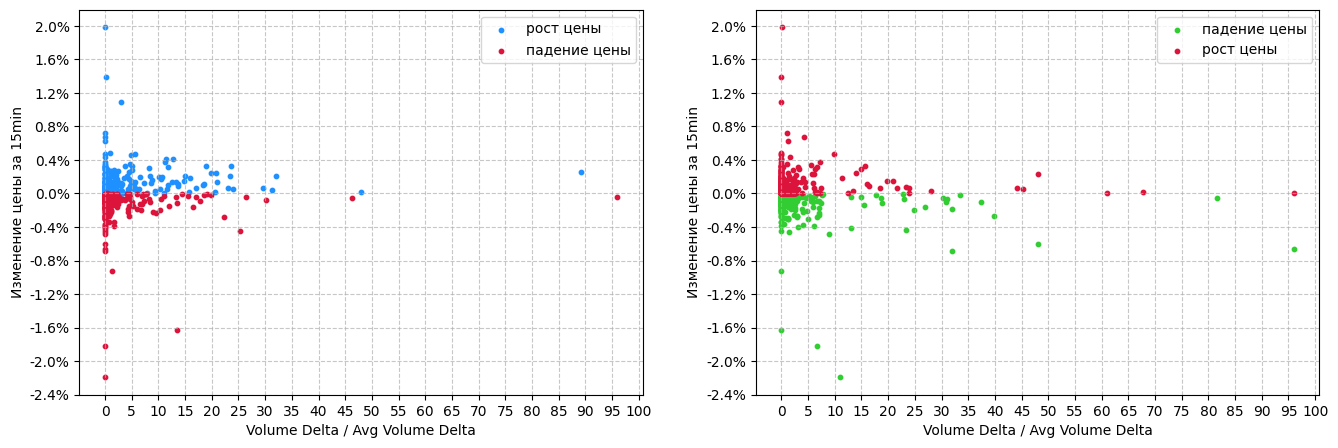

In [ ]:
from matplotlib.ticker import MaxNLocator, MultipleLocator, FuncFormatter

n = 1
ratios = pd.DataFrame({
    'avg_neg': avg_neg_delta,
    'avg_pos': avg_pos_delta,
    'del_neg': neg_delta,
    'del_pos': pos_delta,
    'ratio_pos': (pos_delta / avg_pos_delta),
    'ratio_neg': (neg_delta / avg_neg_delta),
    'delta_price': (P.shift(-n) - P),  # абсолютное изменение цены
    'persent_del_price' : (P.shift(-n))/P - 1
}).dropna()

fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 5)
)

pos_good_case = ratios['delta_price'] >= 0
pos_bad_case = ratios['delta_price'] < 0

neg_good_case = pos_bad_case
neg_bad_case = pos_good_case

axes[0].scatter(ratios[pos_good_case]['ratio_pos'], ratios[pos_good_case]['persent_del_price'], color = 'dodgerblue', s=10, label='рост цены')
axes[0].scatter(ratios[pos_bad_case]['ratio_pos'], ratios[pos_bad_case]['persent_del_price'], color = 'crimson', s=10, label='падение цены')
axes[0].legend(loc='upper right')

axes[1].scatter(ratios[neg_good_case]['ratio_neg'], ratios[neg_good_case]['persent_del_price'], color = 'limegreen', s=10, label='падение цены')
axes[1].scatter(ratios[neg_bad_case]['ratio_neg'], ratios[neg_bad_case]['persent_del_price'], color = 'crimson', s=10, label='рост цены')
axes[1].legend(loc='upper right')

axes[0].set_ylabel(f'изменение цены за {PERIOD_SMALL} в %')
axes[0].set_xlabel('volume delta / avg volume delta')

axes[1].set_ylabel(f'изменение цены за {PERIOD_SMALL} в %')
axes[1].set_xlabel('volume delta / avg volume delta')

for ax in axes:
    # ось y
    ax.yaxis.set_major_locator(MaxNLocator(nbins=15))  # 15 делений по Y
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))

    # ось х
    ax.xaxis.set_major_locator(MultipleLocator(5))
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel(f'Изменение цены за {PERIOD_SMALL}', fontsize=10)
    ax.set_xlabel('Volume Delta / Avg Volume Delta', fontsize=10)

In [ ]:
# import matplotlib.ticker as ticker

# n = 1
# ratios = pd.DataFrame({
#     'avg_neg': avg_neg_delta,
#     'avg_pos': avg_pos_delta,
#     'del_neg': neg_delta,
#     'del_pos': pos_delta,
#     'ratio_pos': (pos_delta / avg_pos_delta),
#     'ratio_neg': (neg_delta / avg_neg_delta),
#     'delta_price': (P.shift(-n) - P)  # абсолютное изменение цены
# }).dropna()

# print(ratios['ratio_pos'], ratios['ratio_neg'])

# # Увеличиваем количество бинов для большей детализации
# num_bins = 10
# pos_x_bins = np.linspace(ratios['ratio_pos'].min(), ratios['ratio_pos'].max(), num_bins)
# pos_y_bins = np.linspace(ratios['delta_price'].min(), ratios['delta_price'].max(), num_bins)

# # Создаем двумерную гистограмму
# H_pos, xedges_pos, yedges_pos = np.histogram2d(
#     ratios['ratio_pos'], 
#     ratios['delta_price'],
#     bins=[pos_x_bins, pos_y_bins]
# )

# # Создаем подписи для ячеек
# annotations = np.full(H.T.shape, "", dtype=object)
# for i in range(len(yedges_pos)-1):
#     for j in range(len(xedges_pos)-1):
#         count = H.T[i, j]
#         if count > 0:
#             # Форматируем число: если >1000 - сокращенная запись (1.2k)
#             count_str = f"{count:.0f}" if count < 1000 else f"{count/1000:.1f}k"
#             annotations[i, j] = count_str

# # Создаем фигуру
# fig, axes = plt.subplots(
#     1, 2,
#     figsize=(12, 8)
#     )

# # Используем логарифмическую шкалу для лучшего отображения
# H_pos_log = np.log1p(H_pos)  # log(1+x) для обработки нулей

# # Рисуем тепловую карту с аннотациями
# pcm = axes[0].pcolormesh(
#     xedges_pos, yedges_pos, H_pos_log.T,
#     cmap='viridis',
#     edgecolors='lightgray',  # добавляем границы ячеек
#     linewidth=0.5
# )

# # Добавляем аннотации
# for i in range(len(yedges_pos)-1):
#     for j in range(len(xedges_pos)-1):
#         if H.T[i, j] > 0:
#             # Центр ячейки для размещения текста
#             x_center = (xedges_pos[j] + xedges_pos[j+1]) / 2
#             y_center = (yedges_pos[i] + yedges_pos[i+1]) / 2
#             axes[0].text(
#                 x_center, y_center, annotations[i, j],
#                 ha='center', va='center',
#                 color='white',
#                 fontsize=8
#             )

# # Настройка цветовой шкалы
# cbar = fig.colorbar(pcm, ax=axes[0])
# cbar.set_label('log(Frequency)')

# # Форматирование осей
# axes[0].set_xlabel('ratio = |ΔV| / mean(|ΔV|)', fontsize=12)
# axes[0].set_ylabel(f'|ΔPrice| over {n} bars', fontsize=12)
# axes[0].set_title('Frequency Heatmap: Ratio vs Price Change', fontsize=14, pad=20)

# # Детальные подписи осей
# axes[0].xaxis.set_major_locator(ticker.MaxNLocator(10))
# axes[0].yaxis.set_major_locator(ticker.MaxNLocator(10))
# axes[0].tick_params(axis='both', which='major', labelsize=9)

# # Добавляем сетку
# # axes[0].grid(True, linestyle='--', alpha=0.3)

# # Оптимизируем layout
# plt.tight_layout()
# plt.show()

расчет TP/SL

вход/выход из позиций

In [ ]:
open_pos_long = (
    indicators_df['vol_open_long']
)

open_pos_short = (
    indicators_df['vol_open_short']
)

#открытие и закрытие позиций
longs_open  = indicators_df.index[ open_pos_long.fillna(False) ].unique()
shorts_open = indicators_df.index[ open_pos_short.fillna(False) ].unique()

In [ ]:
# Параметры стратегии
RISK_REWARD_RATIO = 1.8
RISK_PERCENT = 10 
N_TICKS_SL = 15
VOLATILITY_WINDOW = '24h'
COEFFICENT = 2

df = df.set_index('recv_time')

df['price_diff'] = df['price'].diff().abs()
df['volatility'] = df['price_diff'].rolling(VOLATILITY_WINDOW).mean().bfill()

df = df.reset_index()

ticks = df.set_index('recv_time')['price']
ticks = ticks[~ticks.index.duplicated(keep='first')]

vol_series = df.set_index('recv_time')['volatility']
vol_series = vol_series[~vol_series.index.duplicated(keep='first')]

bars = df.set_index('recv_time').resample('15min').agg(
    high=('price','max'),
    low =('price','min'),
    close=('price','last')
)
bars['prev_close'] = bars['close'].shift()
bars['tr'] = bars.apply(
    lambda r: max(
        r.high - r.low,
        abs(r.high - r.prev_close),
        abs(r.low  - r.prev_close)
    ), axis=1
)
bars['ATR'] = bars['tr'].rolling(window=14).mean().bfill()


def get_nearest_tick(ts):
    pos = ticks.index.get_indexer([ts], method='nearest')[0]
    return pos

def find_exit_point(open_ts, direction):
    variants = {}#добавил   variants['stoploss'] = 
    pos = get_nearest_tick(open_ts)
    atr = bars.loc[open_ts, 'ATR']

    entry_price = ticks.iloc[pos]

    sl_amount = COEFFICENT * atr
    tp_amount = RISK_REWARD_RATIO * COEFFICENT * atr

    future = ticks.iloc[pos+1:] 

    if direction == 'long':
        sl_price = entry_price - sl_amount
        tp_price = entry_price + tp_amount

        ts_sl = future[future <= sl_price].index.min() if not future[future <= sl_price].empty else None
        ts_tp = future[future >= tp_price].index.min() if not future[future >= tp_price].empty else None
    else:
        sl_price = entry_price + sl_amount
        tp_price = entry_price - tp_amount

        ts_tp = future[future <= tp_price].index.min() if not future[future <= tp_price].empty else None
        ts_sl = future[future >= sl_price].index.min() if not future[future >= sl_price].empty else None

    # variants['ts_sl'] = ts_sl
    # variants['sl_price'] = sl_price
    # variants['ts_tp'] = ts_tp
    # variants['tp_price'] = tp_price

    if ts_sl is not None and ts_tp is not None:
        return (min(ts_sl, ts_tp), sl_price)

    # return variants
    return (ts_sl, sl_price) or (ts_tp, sl_price)

#добавил variants и longs_sl
longs_close  = [find_exit_point(ts, 'long')  for ts in longs_open]
shorts_close = [find_exit_point(ts, 'short') for ts in shorts_open]
# longs_sl = []
# longs_close = []

# for ts in longs_open:
#     variants = find_exit_point(ts, 'long')

#     ts_sl = variants['ts_sl']
#     sl_price = variants['sl_price']
#     ts_tp = variants['ts_tp']
#     # tp_price = variants['tp_price']

#     temp = {
#         'sl_price': sl_price,
#         'sl_time': ts_sl
#     }
#     longs_sl.append(temp)

#     longs_close.append(min(ts_sl, ts_tp))

# shorts_sl = []
# shorts_close = []

# for ts in shorts_open:
#     variants = find_exit_point(ts, 'short')

#     ts_sl = variants['ts_sl']
#     sl_price = variants['sl_price']
#     ts_tp = variants['ts_tp']

#     temp = {
#         'sl_price': sl_price,
#         'sl_time': ts_sl
#     }
#     longs_sl.append(temp)

#     longs_close.append(min(ts_sl, ts_tp))

print(f'longs close\n{longs_close}')

longs close
[(Timestamp('2025-07-13 12:05:27.916000'), np.float64(116678.52901785714)), (None, np.float64(114831.24665178571)), (Timestamp('2025-07-15 23:00:07.459000'), np.float64(115497.859375)), (Timestamp('2025-07-20 14:01:57.842000'), np.float64(117514.94642857143)), (Timestamp('2025-07-20 14:06:26.652000'), np.float64(117654.14174107143)), (Timestamp('2025-07-20 07:44:49.062000'), np.float64(117639.375)), (Timestamp('2025-07-21 18:48:00.660000'), np.float64(117137.17410714286)), (Timestamp('2025-07-22 20:02:02.146000'), np.float64(116047.67075892857)), (Timestamp('2025-07-22 23:14:10.031000'), np.float64(118822.15401785714)), (Timestamp('2025-07-24 15:01:06.100000'), np.float64(117545.9140625)), (Timestamp('2025-07-24 14:13:28.893000'), np.float64(117860.65401785714)), (Timestamp('2025-07-24 15:00:33.668000'), np.float64(117675.85714285714)), (Timestamp('2025-07-27 17:48:33.338000'), np.float64(117608.35491071429)), (Timestamp('2025-07-27 22:00:11.019000'), np.float64(118408.8459

соотнесение временных меток с ценами и создания списков трейдов

In [ ]:
trades = []

for open_ts, close_ts in zip(longs_open, longs_close):
    if close_ts[0] is None:
        continue

    #посмотреть тут мб проблема 
    pos_o = get_nearest_tick(open_ts)
    pos_c = get_nearest_tick(close_ts[0])

    actual_open_ts  = ticks.index[pos_o]
    actual_close_ts = ticks.index[pos_c]

    entry_price = ticks.iloc[pos_o]
    exit_price  = ticks.iloc[pos_c]

    trades.append({
        'direction':   'long',
        'entry_time':  actual_open_ts,
        'exit_time':   actual_close_ts,
        'entry_price': entry_price,
        'exit_price':  exit_price,
        'profit':      exit_price - entry_price,
        'return':      (exit_price - entry_price) / entry_price,
        'sl_price':    close_ts[1]
    })

for open_ts, close_ts in zip(shorts_open, shorts_close):
    if close_ts[0] is None:
        continue

    pos_o = get_nearest_tick(open_ts)
    pos_c = get_nearest_tick(close_ts[0])

    actual_open_ts  = ticks.index[pos_o]
    actual_close_ts = ticks.index[pos_c]

    entry_price = ticks.iloc[pos_o]
    exit_price  = ticks.iloc[pos_c]

    trades.append({
        'direction':   'short',
        'entry_time':  actual_open_ts,
        'exit_time':   actual_close_ts,
        'entry_price': entry_price,
        'exit_price':  exit_price,
        'profit':      entry_price - exit_price,
        'return':      (entry_price - exit_price) / entry_price,
        'sl_price':    close_ts[1]
    })

расчет доходности стратегии

In [ ]:
price_ser    = df.set_index('recv_time')['price']
DEPOSIT = 10_000
FEE = 0.00075
equity = [DEPOSIT]
times  = [trades[0]['entry_time'] if trades else df['recv_time'].iloc[0]]
for tr in trades:
    if tr['direction'] == 'long':
        ret = (tr['exit_price'] - tr['entry_price']) / tr['entry_price']
    else:
        ret = (tr['entry_price'] - tr['exit_price']) / tr['entry_price']

    pos_size = (RISK_PERCENT * equity[-1]) * COEFFICENT / (tr['entry_price'] - tr['sl_price'])
    pnl = pos_size * ret
    notional_entry = pos_size
    notional_exit  = pos_size * (exit_price / entry_price)
    commission = (notional_entry + notional_exit) * FEE
    net_pnl = pnl - commission

    equity.append(equity[-1] + pnl)
    times.append(tr['exit_time'])

    # print(f'dir: {tr['direction']}\nentry time: {tr['entry_time']}\n exit time: {tr['exit_time']} \npnl:{pnl}')

# 5) Расчёт buy&hold
bh_price = price_ser
bh_equity = DEPOSIT * (bh_price / bh_price.iloc[0])



отрисовка точек входа на цене

C:\Users\382he\AppData\Local\Temp\ipykernel_16312\3548420148.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(loc='best')
C:\Users\382he\AppData\Local\Temp\ipykernel_16312\3548420148.py:83: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.15)  # Увеличиваем место снизу для меток времени


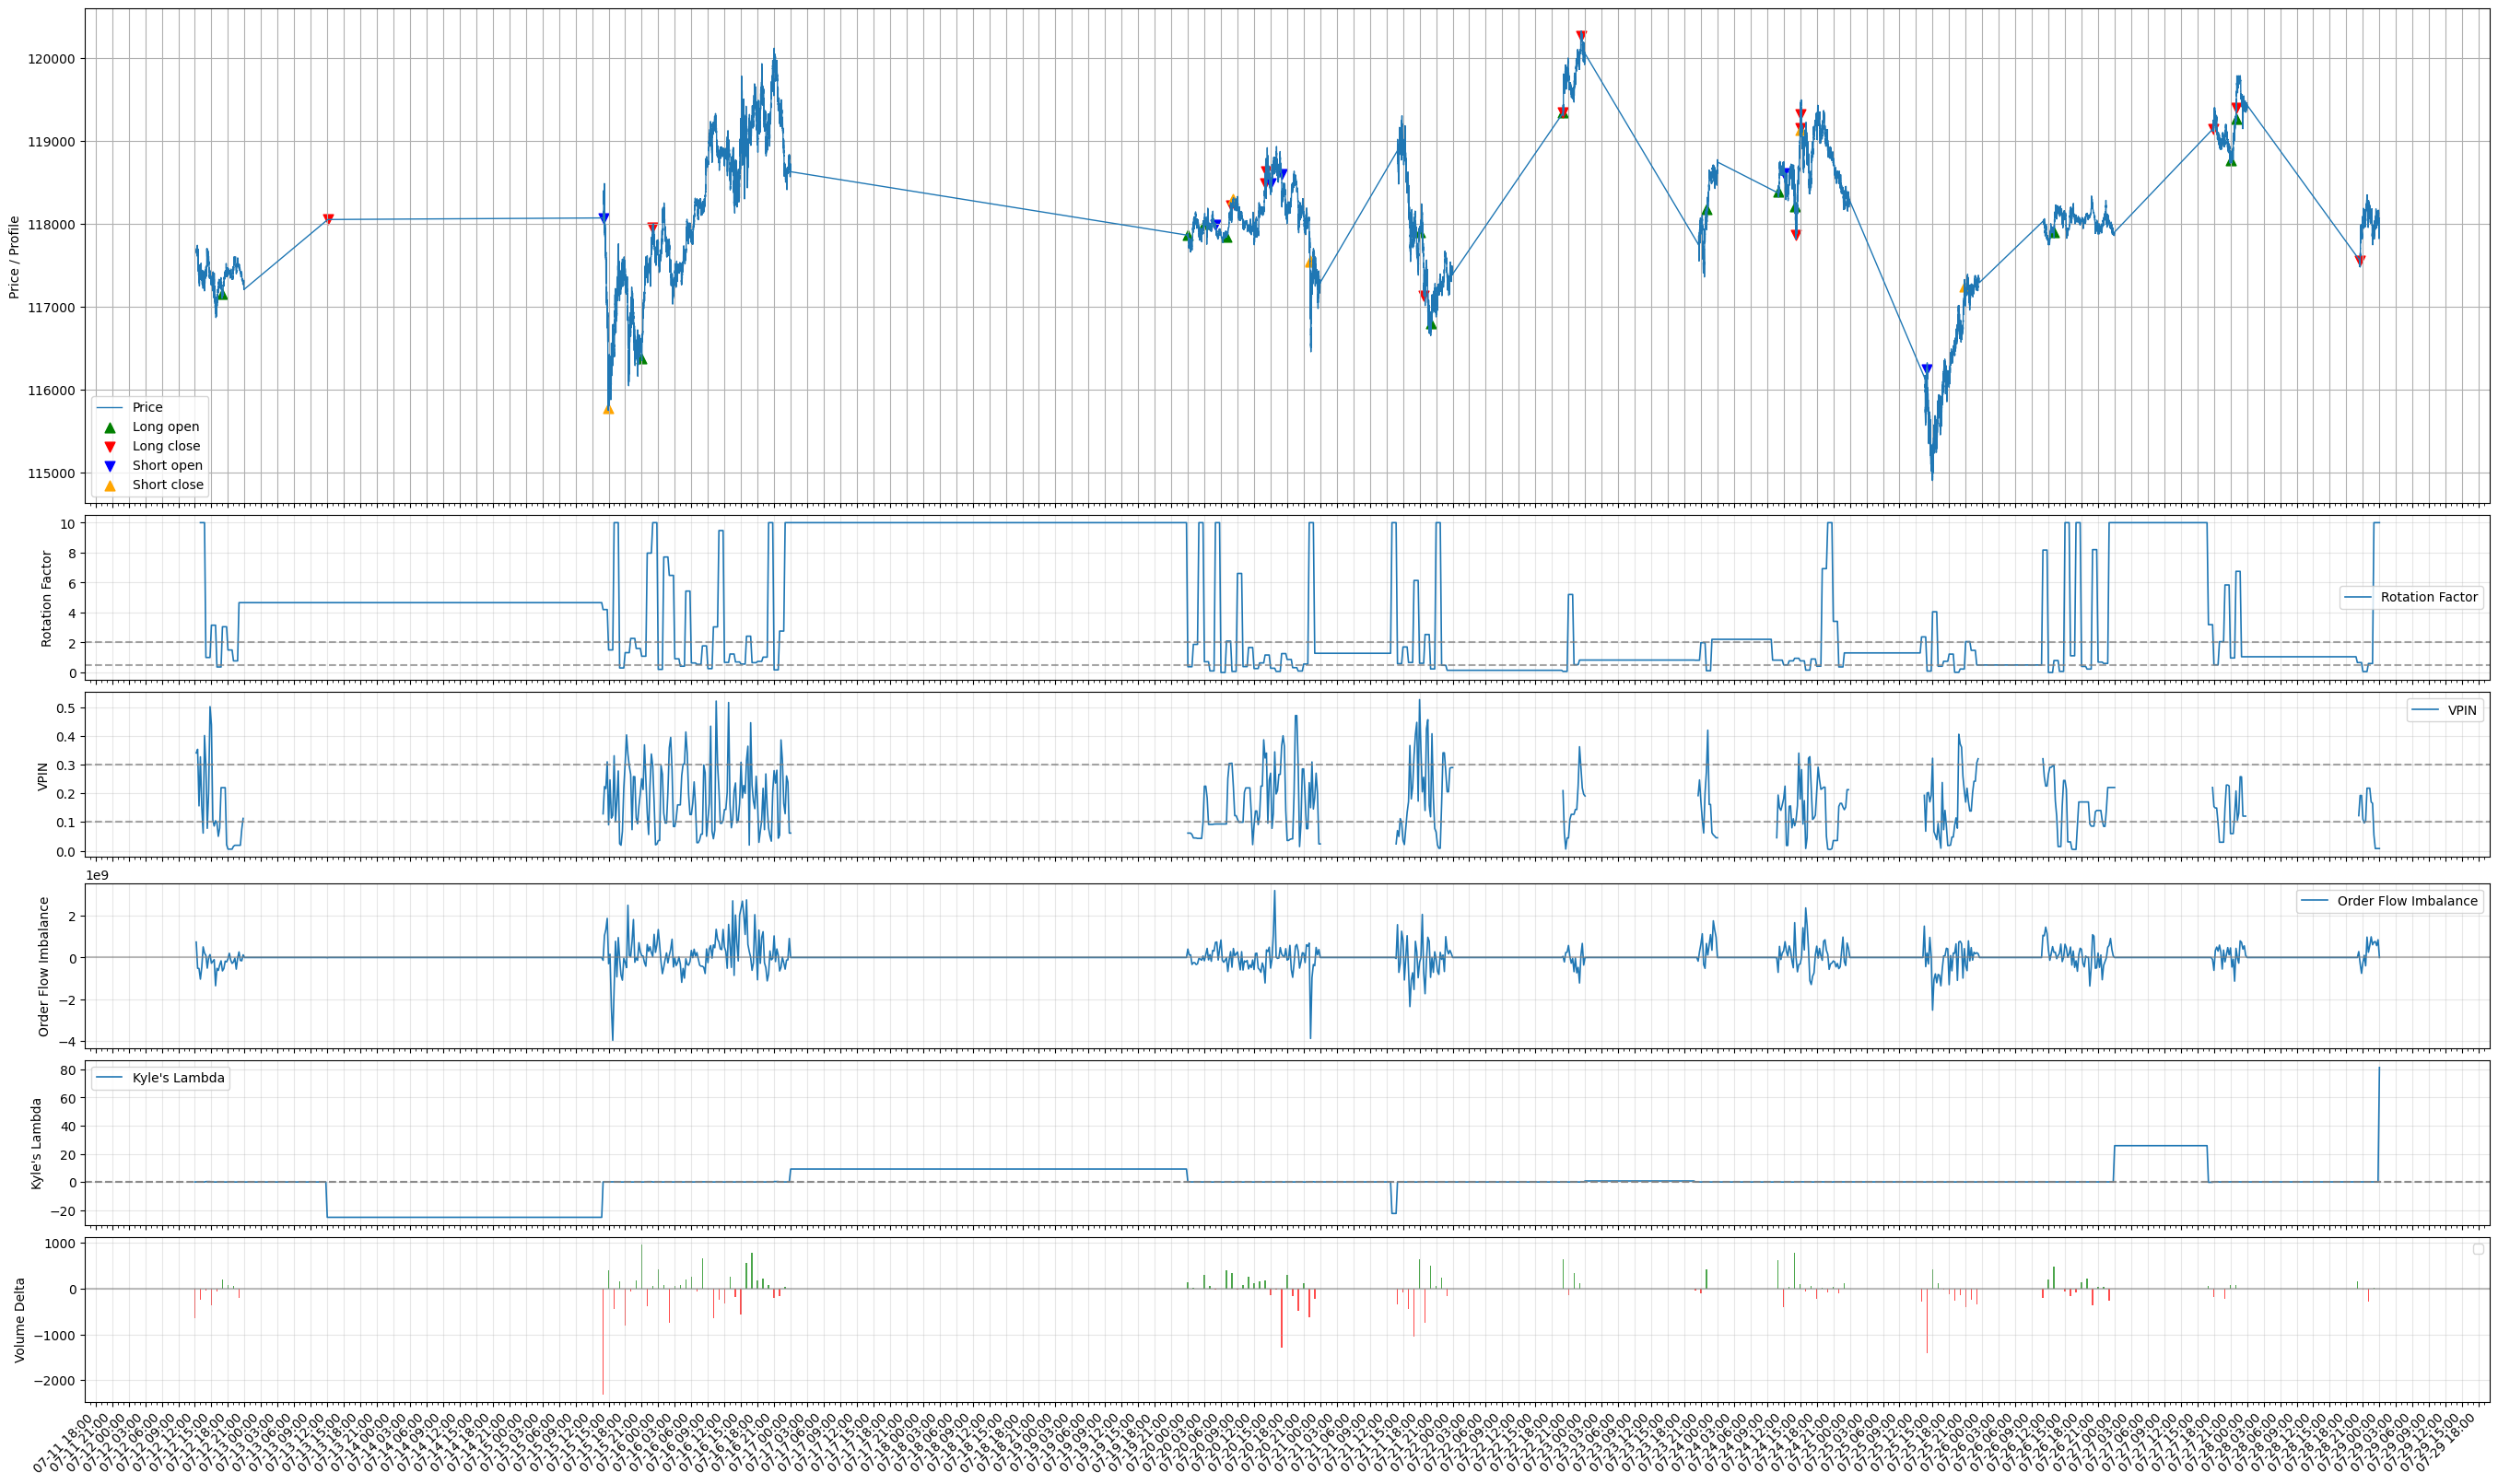

In [ ]:
fig, axes = plt.subplots(
    6, 1,
    figsize=(27, 16),
    constrained_layout=True,
    sharex=True,
    gridspec_kw={'height_ratios': [3, 1, 1, 1, 1, 1]}
)
ax0 = axes[0]

# Рисуем цену
ax0.plot(df['recv_time'], df['price'], label='Price', linewidth=1)

# 1) Разделяем trades на два списка
trades_long  = [t for t in trades if t['direction'] == 'long']
trades_short = [t for t in trades if t['direction'] == 'short']

# 2) Извлекаем отдельно entry/exit времена и цены для каждого направления
long_open_times  = [t['entry_time']  for t in trades_long]
long_open_prices = [t['entry_price'] for t in trades_long]
long_close_times  = [t['exit_time']  for t in trades_long]
long_close_prices = [t['exit_price'] for t in trades_long]

short_open_times  = [t['entry_time']   for t in trades_short]
short_open_prices = [t['entry_price']  for t in trades_short]
short_close_times  = [t['exit_time']   for t in trades_short]
short_close_prices = [t['exit_price']  for t in trades_short]

# 3) Наносим на график

ax0.scatter(long_open_times,  long_open_prices,  marker='^', color='g', s=60, label='Long open')
ax0.scatter(long_close_times, long_close_prices, marker='v', color='r', s=60, label='Long close')

ax0.scatter(short_open_times,  short_open_prices,  marker='v', color='b',      s=60, label='Short open')
ax0.scatter(short_close_times, short_close_prices, marker='^', color='orange', s=60, label='Short close')

ax0.set_ylabel("Price / Profile")
ax0.legend(loc='lower left')
ax0.grid(True)

indicators = ['RF','VPIN','OFI','Kyle_Lambda','volume_delta']
titles = ['Rotation Factor', 'VPIN', 'Order Flow Imbalance', "Kyle's Lambda", 'Volume Delta']

for i, indicator in enumerate(indicators, start=1):
    if indicator == 'volume_delta':
        # Особый случай для volume delta - используем бары
        colors = np.where(indicators_df[indicator] >= 0, 'green', 'red')
        axes[i].bar(indicators_df.index, indicators_df[indicator], color=colors, alpha=0.7, width=0.01)
        axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    else:
        axes[i].plot(indicators_df.index, indicators_df[indicator], label=titles[i-1], linewidth=1.2)
    
    #ключевые уровни для каждого индикатора
    if indicator == 'RF':
        axes[i].axhline(0.5, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(2.0, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'VPIN':
        axes[i].axhline(0.1, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(0.3, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'Kyle_Lambda':
        axes[i].axhline(0.05, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(0.2, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'OFI':
        axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    
    axes[i].set_ylabel(titles[i-1])
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='best')

# Форматирование времени на последнем графике
for ax in axes:
    # 1. Устанавливаем локатор дат (каждые 3 часа)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    
    # 2. Формат с датой и временем
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    
    # 3. Дополнительные минорные деления (каждый час)
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    
    # 4. Поворот меток
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.subplots_adjust(bottom=0.15)  # Увеличиваем место снизу для меток времени
# plt.tight_layout()
plt.show()

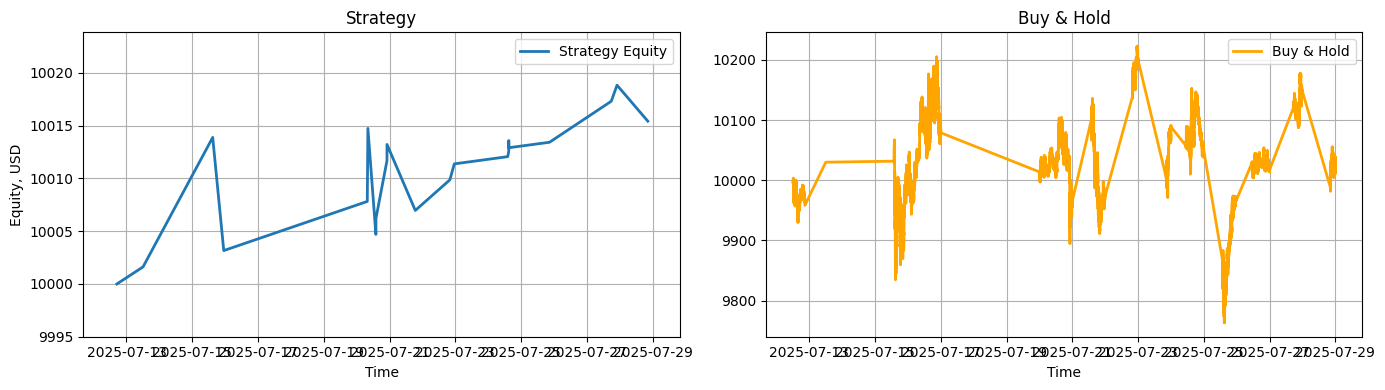

Strategy returns:
0.0013430615084584134 %, Balance: 10013.430615084584
Buy&Hold returns:
0.003159795385608777 %, Balance: 10031.597953856088


C:\Users\382he\AppData\Local\Temp\ipykernel_16312\2589324661.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/10000} %, Balance: {bh_equity[-1]}')


In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,4),sharex=True, sharey=False)

# Стратегия
pts = sorted(zip(times, equity), key=lambda x: x[0])
times_sorted, equity_sorted = zip(*pts)

ax0.plot(times_sorted, equity_sorted, label='Strategy Equity', linewidth=2)
ax0.set_title("Strategy")
ax0.set_xlabel("Time")
ax0.set_ylabel("Equity, USD")
ax0.legend()
ax0.grid(True)
# Сузим диапазон Y, чтобы мелкие изменения было видно:
y_min = min(equity)*0.9995
y_max = max(equity)*1.0005
ax0.set_ylim(y_min, y_max)

# Buy & Hold
ax1.plot(bh_equity.index, bh_equity.values, 
         label='Buy & Hold', color='orange', linewidth=2)
ax1.set_title("Buy & Hold")
ax1.set_xlabel("Time")
ax1.legend()
ax1.grid(True)


plt.tight_layout()
plt.show()

print(f'Strategy returns:\n{(equity[-1]-equity[0])/10000} %, Balance: {equity[-1]}')
print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/10000} %, Balance: {bh_equity[-1]}')